![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [426]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import re  #  for regular expressions
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer
  #  for analysys

import random

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/world-cities/worldcities.csv
/kaggle/input/cities-of-the-world/cities15000.csv


In [427]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [428]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [429]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [430]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [431]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [432]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [433]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [434]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [435]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [436]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [437]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [438]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
5412,id_5412,Prague,"['Pub', 'Diner', 'Gastropub']",1771.0,NaN,5.0,"[[], []]",/Restaurant_Review-g274707-d12547707-Reviews-P...,d12547707,0,0.0
46718,id_2552,Barcelona,"['Bar', 'Mediterranean', 'European', 'Fusion',...",2553.0,$$ - $$$,7.0,"[['Amazing', 'estupendo!'], ['12/30/2017', '12...",/Restaurant_Review-g187497-d13283806-Reviews-C...,d13283806,1,5.0
24591,id_1572,Prague,['Fast Food'],1575.0,$,29.0,"[['Delicious sandwiches', 'Regular breaky'], [...",/Restaurant_Review-g274707-d7246389-Reviews-Ba...,d7246389,1,4.0
24862,id_14425,London,"['Bar', 'Pub']",14436.0,$$ - $$$,25.0,"[['Never serving any food', 'Fantastic wine ta...",/Restaurant_Review-g186338-d6612776-Reviews-Th...,d6612776,1,3.0
10079,id_35,Budapest,"['Seafood', 'Mediterranean', 'European', 'Gree...",36.0,$$ - $$$,2340.0,"[['Awesome place!', 'one of the nest and great...",/Restaurant_Review-g274887-d696117-Reviews-Tav...,d696117,1,4.5


In [439]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [440]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [441]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [442]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
median_reviews = data['Number of Reviews'].median()
data['Number of Reviews'].fillna(median_reviews, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [443]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1573
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

### Ответ: 'City', 'Price_Range', 'Cuisine Style'(после обработки)

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [444]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City', ])

In [445]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [446]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
2855,id_2855,"['Italian', 'Mediterranean', 'Vegetarian Frien...",3463.0,$$ - $$$,55.0,"[['Wow!', 'Poor food and service, amd expensiv...",/Restaurant_Review-g187791-d8596502-Reviews-Me...,d8596502,0,0.0,...,0,0,0,0,0,1,0,0,0,0
27635,id_8673,['Cafe'],8682.0,NaN,5.0,"[['Perfect!', 'Great little place for lunch'],...",/Restaurant_Review-g186338-d8418837-Reviews-La...,d8418837,1,5.0,...,0,0,0,0,0,0,0,0,0,0
31442,id_7486,"['Japanese', 'Sushi']",7487.0,NaN,12.0,"[['Far from their target', 'ho-hum'], ['11/27/...",/Restaurant_Review-g187497-d2370538-Reviews-Su...,d2370538,1,3.0,...,0,0,0,0,0,0,0,0,0,0
49893,id_2037,['Pizza'],2038.0,$$ - $$$,274.0,"[['OTTIᗰO'], ['03/24/2017']]",/Restaurant_Review-g187791-d2322367-Reviews-La...,d2322367,1,4.0,...,0,0,0,0,0,1,0,0,0,0
38487,id_6039,"['Steakhouse', 'Argentinean', 'Brazilian', 'Ba...",6041.0,$$ - $$$,120.0,"[['Delicious meat and nice short show', 'It sm...",/Restaurant_Review-g187323-d1556946-Reviews-Br...,d1556946,1,3.5,...,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [447]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

### Скорее всего, данные берутся от среднего чека в ресторане. 
Считаю разумным "умножение" каждого значка "доллар" на  10. 
Тогда среднее соответствует значению 25. Сначала избавимся от пропусков в данных:

In [448]:
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace = True)   #   заполняем пропуски модой

In [449]:
data['Price Range'] = data['Price Range'].\
apply(lambda x: 25 if x.__contains__('-') else x.count('$')*10)   
#   преобразуем Price Range и создаем признак по значению среднего чека

In [450]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,25,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,25,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,25,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,40,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,40,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [451]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [452]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 42 columns):
Restaurant_id              50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
Reviews                    49998 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barcelona             50000 non-null uint8
City_Berlin                50000 non-null uint8
City_Bratislava            50000 non-null uint8
City_Brussels              50000 non-null uint8
City_Budapest              50000 non-null uint8
City_Copenhagen 

### Reviews

#### Избавляемся от 2-х пропусков в Reviews, заполним их эквивалентом пустых списков:

In [453]:
data['Reviews'].fillna('[[], []]', inplace = True)   

#### Далее, преобразуем данные в Reviews в 2 столбца: список дат отзывов и список текстов отзывов. 
#### Это пригодится при создании нового признака : "позитивности отзыва"

In [454]:
'''Функция, выделяющая даты в отзыве и преобразующая их в формат dt'''
def parsingdate(review):
    pattern = r'\d{2}/\d{2}/\d{4}'
    result = re.findall(pattern, review)   #   все даты преобразуются в список(с помощью модуля re)
    return pd.to_datetime(result)   #   возвращаем даты в формате списка объектов datetime
data['Reviews_dates'] = data['Reviews'].apply(parsingdate)  #  выделяем даты из Reviews, создаем столбец со списком из дат отзывов

In [455]:
data['Reviews_texts'] = data.Reviews.apply(lambda x: x.split('], [')[0][3:-1].split('\', \''))   
#  тексты отзывов преобразуем в список из отзывов

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

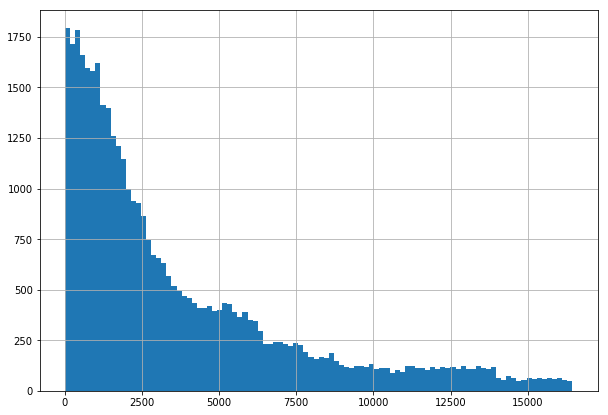

In [456]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

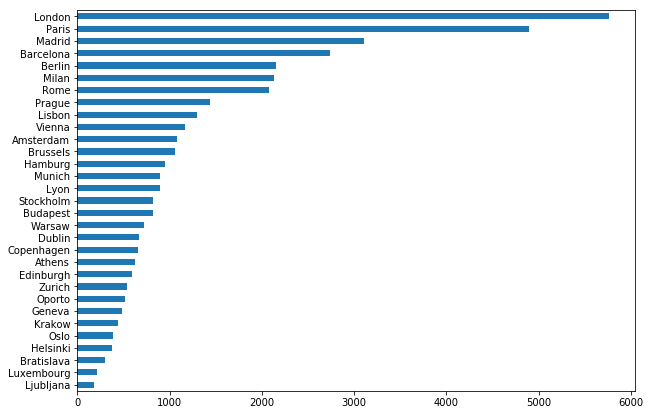

In [457]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

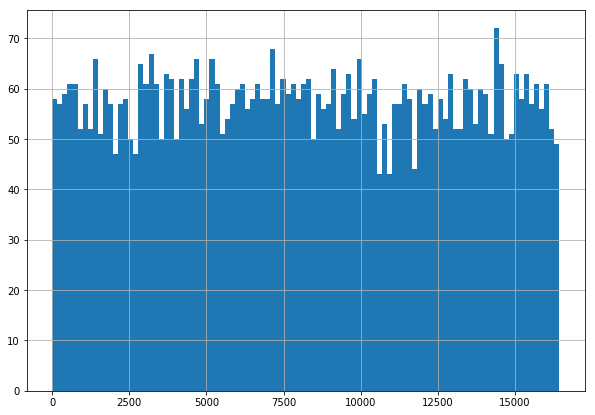

In [458]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

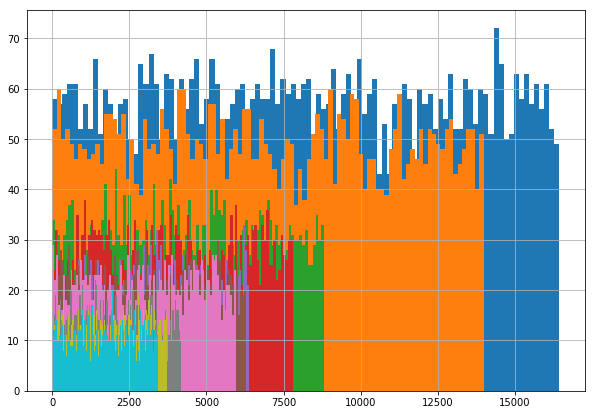

In [459]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

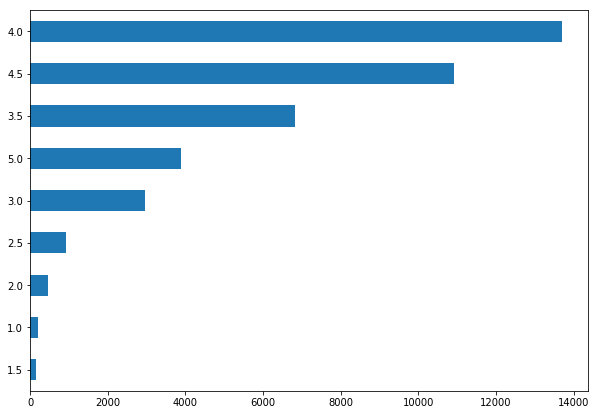

In [460]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

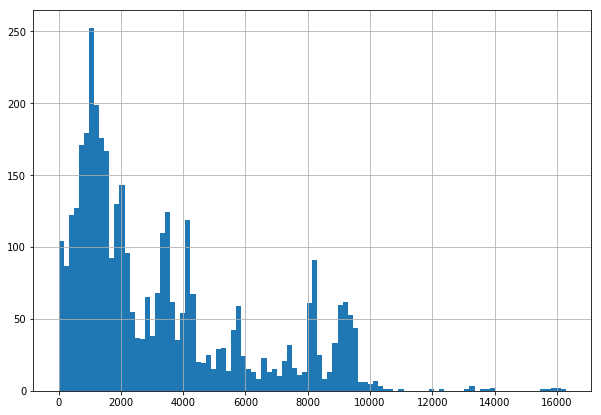

In [461]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

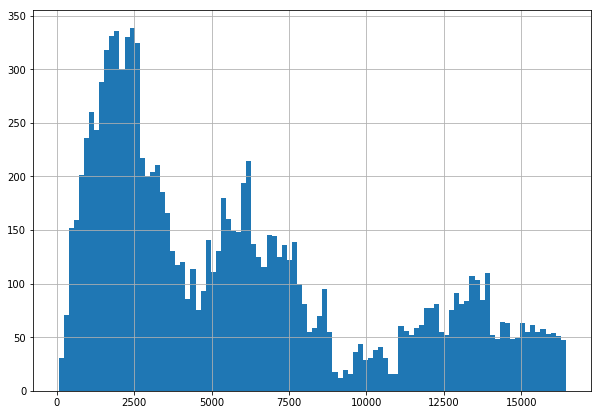

In [462]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

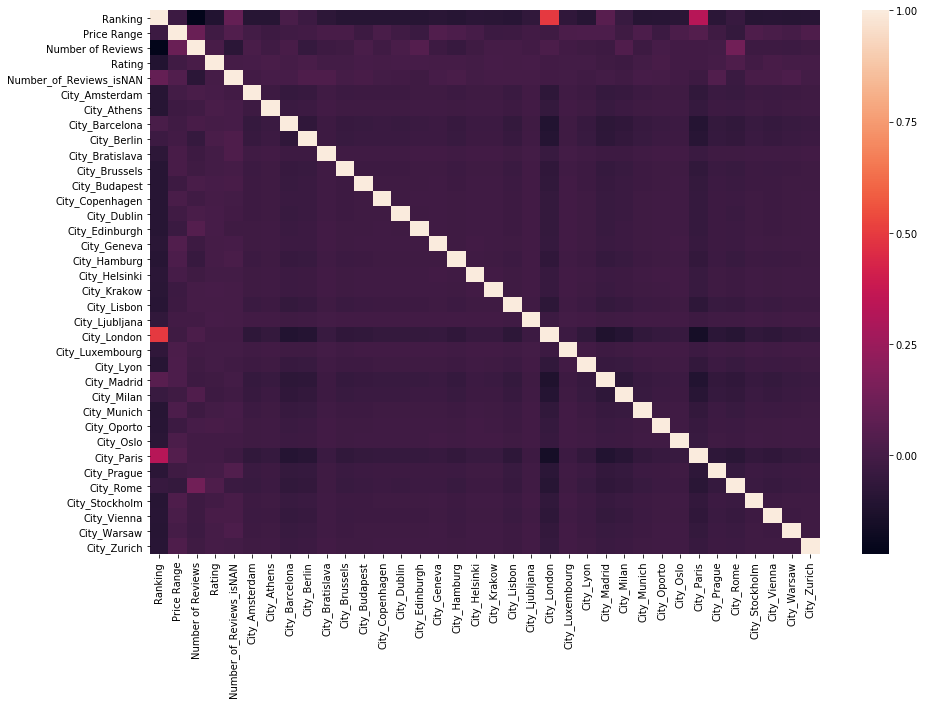

In [463]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

### Создаем признак по тональности отзыва.
#### Если отзыв старый, считаем его неактуальным.

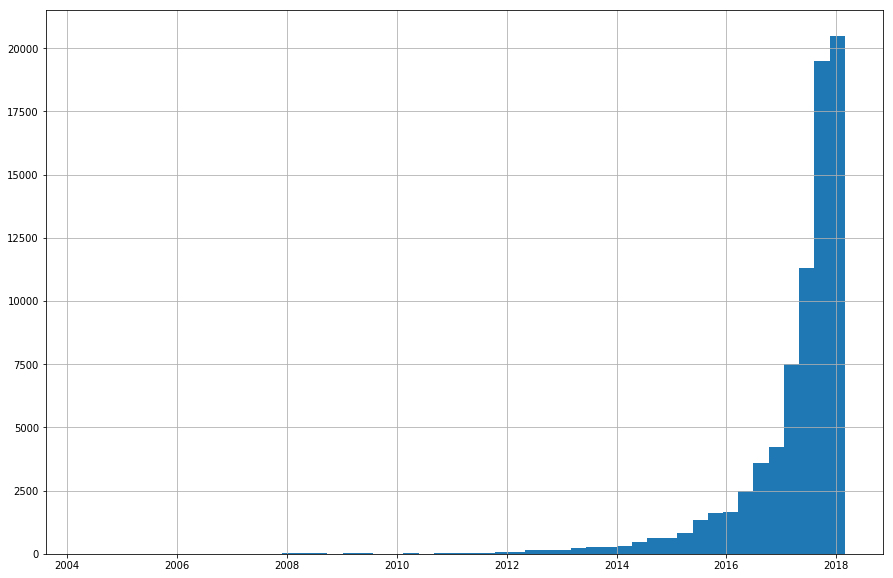

In [464]:
all_dates = []

for date_list in data['Reviews_dates'].values:   #  объединяем все даты отзывов
    for date in date_list:
        all_dates.append(date)
        
pd.Series(all_dates).hist(bins=50)    #    смотрим распределение отзывов по годам
non_actual_time = pd.Series(all_dates).quantile(0.1).year   #   до 2016 года отзывы можно считать неактуальными

#### Создаем новый признак, "позитивность отзывов"(**Positivity_of_reviews**):
#### для этого для каждого отзыва:вычисляем показатель позитивности отзыва, 
#### если отзыв актуальный(по дате) оставляем показатель как есть, если нет заменяем его на 0.5 - полностью нейтральный. И находим среднее значение позитивности двух отзывов.

In [465]:
tb = Blobber(analyzer=NaiveBayesAnalyzer())   #  если вызывать анализатор внутри функции производительность сильно снизится.
'''Функция, возвращающая значение, показывающее, насколько позитивен введенный текст'''
def positive_grade(text):
    return tb(text).sentiment[1]

Создаем новый признак, "позитивность отзывов"(**positivity_of_reviews**):
для этого для каждого отзыва: умножаем показатель позитивности отзыва на 1, если отзыв актуальный и на 0, если нет. И находим среднее значение позитивности двух отзывов.

In [466]:
positive_grade(data.Reviews_texts[1][0])   #   Запускаем analyzer для проверки

0.6078957633862684

In [467]:
'''Функция, возвращающая значение, показывающее, насколько позитивны отзывы в ресторане, учитывая их актульность'''
def positivity(reviews,dates,non_actual_time):
    if len(dates) == 0:
        return 0.5
    result_values = []
    for i,review in enumerate(reviews):
        if (dates[i].year < non_actual_time):
            result_values.append(0.5)
        else:
            result_values.append(positive_grade(review))
    return sum(result_values)/len(result_values)

In [468]:
data['Positivity_of_reviews'] = data.\
apply(lambda x: positivity(x.Reviews_texts, x.Reviews_dates, non_actual_time), axis=1) 
#   создание признака "позитивности отзывов" ресторана

In [469]:
data['Positivity_of_reviews'].head(10)

0    0.500000
1    0.649425
2    0.406276
3    0.865862
4    0.471692
5    0.318885
6    0.500000
7    0.500000
8    0.542686
9    0.597674
Name: Positivity_of_reviews, dtype: float64

In [470]:
data['Positivity_of_reviews'].corr(data['Rating'])

0.06803228284969004

### Признак население города относительно Ranking

In [471]:
data_old = df_test.append(df_train, sort=False).reset_index(drop=True)   #   заново подгружаем данные
cities_source = pd.read_csv('../input/world-cities/worldcities.csv')   
#   данные из библиотеки данных kaggle с численностью населения городов
cities = cities_source[['city','population']]
cities.columns = ['City', 'Population']
cities_from_data = data_old['City'].unique()
cities = cities.sort_values(by =['Population','City'])
cities.drop_duplicates(subset='City', keep='last', inplace=True)   #   убираем мелкие города
difference = set(data_old.City.values) - set(cities.City.values)   #  находим города, которых нет во внешней базе
new_cities = list(difference)
new_cities

['Krakow', 'Oporto', 'Zurich']

In [472]:
new_populations = [779115, 287591, 434008]
add_to_cities = pd.DataFrame({ 'City': new_cities, 'Population': new_populations })
cities = cities.append(add_to_cities, ignore_index=True)   #   добавляем города без значения населения

In [473]:
merged_data = data_old.merge(cities, how='inner')   #   присоединяем значение населения к датасету
data_old = merged_data

In [474]:
data = data.join(data_old['Population'])
data['Ranking_on_population'] = data['Ranking']/data['Population']   
#   создаем новый признак ранга в зависимости от населения города

In [475]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Reviews_dates,Reviews_texts,Positivity_of_reviews,Population,Ranking_on_population
0,id_0,"['Bar', 'Pub']",12963.0,25,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,"DatetimeIndex([], dtype='datetime64[ns]', freq...",[],0.500000,11020000.0,0.001176
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,25,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,"DatetimeIndex(['2017-12-05', '2017-10-29'], dt...","[Very good reviews!, Fine dining in Hakaniemi]",0.649425,11020000.0,0.000010
2,id_2,['Vegetarian Friendly'],810.0,25,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,"DatetimeIndex(['2017-12-28', '2017-12-06'], dt...","[Better than the Links, Ivy Black]",0.406276,11020000.0,0.000074
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,40,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,"DatetimeIndex(['2017-12-06', '2017-11-22'], dt...","[Most exquisite, Delicious and authentic]",0.865862,11020000.0,0.000151
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,40,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,"DatetimeIndex(['2018-02-08', '2018-01-24'], dt...","[Always the best in bratislava, Very good but ...",0.471692,11020000.0,0.000003


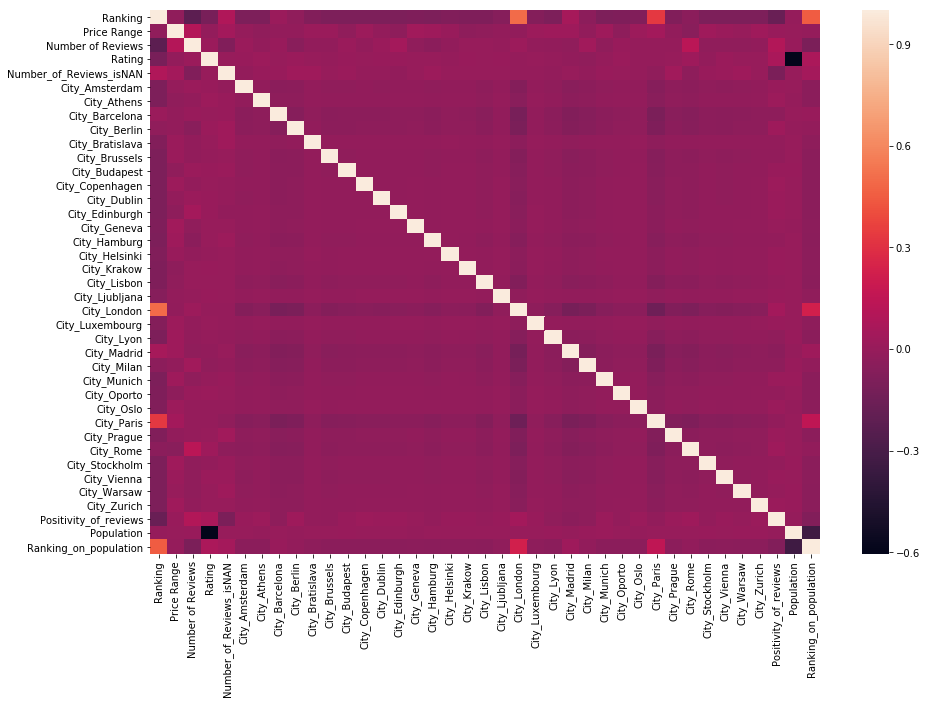

In [476]:
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

### Признаки Cuisine Style

In [477]:
cuisines = Counter(data['Cuisine Style'].dropna().apply(lambda x: x[1:-1]).str.split(', ').sum())
cuisines_s = pd.Series(cuisines)
cuisines_s[cuisines_s == cuisines_s.max()]   #   наиболее часто встречающаяся кухня


'Vegetarian Friendly'    14021
dtype: int64

In [478]:
data['Cuisine Style'].fillna('Vegetarian Friendly', inplace=True)   #   заполняем пропуски "Вегетарианской кухней"
cuisine_format = data['Cuisine Style'].apply(lambda x: x[1:-1]).str.split(', ')


'''Функция, ликвидирующая кавычки в списке со строковыми данными'''
def no_quotes(values):
    new_list=[]
    for value in values:
        if (values == ['Vegetarian Friendly']):
            new_list.append(value)
        else:
            new_list.append(value[1:-1])
    return new_list


data['Cuisine Format'] = cuisine_format.apply(no_quotes)   #  Применяем no_quotes для списков кухонь
data.head(2)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Reviews_dates,Reviews_texts,Positivity_of_reviews,Population,Ranking_on_population,Cuisine Format
0,id_0,"['Bar', 'Pub']",12963.0,25,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,"DatetimeIndex([], dtype='datetime64[ns]', freq...",[],0.500000,11020000.0,0.001176,"[Bar, Pub]"
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,25,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,"DatetimeIndex(['2017-12-05', '2017-10-29'], dt...","[Very good reviews!, Fine dining in Hakaniemi]",0.649425,11020000.0,0.000010,"[European, Scandinavian, Gluten Free Options, ..."


In [479]:
for_dummies_data = data['Cuisine Format'].reset_index()
for_dummies_data.columns = ['Flag', 'Cuisine']
for_dummies_data['Flag'] = pd.Series([random.choice('qwertyuioplkjhgfdsazxcvbnm')+str(i) for i in range(50000)])
# создаем уникальный id, подготавливаем данные для анализа
data = data.join(for_dummies_data['Flag'])   #   в основном датасете нужен такой же Flag

In [480]:
dummies_data = pd.get_dummies(
 for_dummies_data.join(pd.Series(for_dummies_data['Cuisine'].apply(pd.Series).stack().reset_index(1, drop=True),
                    name='Cuisine1')).drop('Cuisine', axis=1).rename(columns={'Cuisine1': 'Cuisine'}),
    columns=['Cuisine']).groupby('Flag', as_index=False).sum()
dummies_data.head()

,Flag,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,...,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan,Cuisine_getarian Friend
0,a10007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,a10020,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,a10033,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,a10050,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,a10076,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [481]:
dummies_data['Cuisine_Vegetarian Friendly'] = dummies_data['Cuisine_Vegetarian Friendly'] \
+ dummies_data['Cuisine_getarian Friend']   #   замечено неправильное значение, объединяем с правильным
dummies_data.drop('Cuisine_getarian Friend',axis=1,inplace=True)
dummies_data.head(2)

,Flag,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,Cuisine_Argentinean,Cuisine_Armenian,Cuisine_Asian,Cuisine_Australian,...,Cuisine_Ukrainian,Cuisine_Uzbek,Cuisine_Vegan Options,Cuisine_Vegetarian Friendly,Cuisine_Venezuelan,Cuisine_Vietnamese,Cuisine_Welsh,Cuisine_Wine Bar,Cuisine_Xinjiang,Cuisine_Yunnan
0,a10007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,a10020,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [482]:
data = data.merge(dummies_data, on='Flag', how='inner', suffixes=('_data','_dum'))

In [483]:
data.info(138)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 174 columns):
Restaurant_id                  object
Cuisine Style                  object
Ranking                        float64
Price Range                    int64
Number of Reviews              float64
Reviews                        object
URL_TA                         object
ID_TA                          object
sample                         int64
Rating                         float64
Number_of_Reviews_isNAN        uint8
City_Amsterdam                 uint8
City_Athens                    uint8
City_Barcelona                 uint8
City_Berlin                    uint8
City_Bratislava                uint8
City_Brussels                  uint8
City_Budapest                  uint8
City_Copenhagen                uint8
City_Dublin                    uint8
City_Edinburgh                 uint8
City_Geneva                    uint8
City_Hamburg                   uint8
City_Helsinki               

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [484]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [485]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    data = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    data.drop(['Restaurant_id','ID_TA','URL_TA'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    data['Number of Reviews'].fillna(0, inplace=True)
    # заполняем строковым значением пустого списка
    
    data['Reviews'].fillna('[[], []]', inplace=True)
    
    cuisines = Counter(data['Cuisine Style'].dropna().apply(
    lambda x: x[1:-1]).str.split(', ').sum())
    
    cuisines_s = pd.Series(cuisines)
    # наиболее часто встречающаяся кухня
    cuisines_s[cuisines_s == cuisines_s.max()]
    data['Cuisine Style'].fillna('Vegetarian Friendly', inplace=True) 
    
    data['Price Range'].fillna(data['Price Range'].mode()[
                           0], inplace=True)  # заполняем пропуски модой
    
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    
    #   Кухни
    cuisine_format = data['Cuisine Style'].apply(lambda x: x[1:-1]).str.split(', ')
    


    '''Функция, ликвидирующая кавычки в списке со строковыми данными'''
    def no_quotes(values):
        new_list = []
        for value in values:
            if (values == ['Vegetarian Friendly']):
                new_list.append(value)
            else:
                new_list.append(value[1:-1])
        return new_list


    data['Cuisine Format'] = cuisine_format.apply(
    no_quotes)  # Применяем no_quotes для списков кухонь
    for_dummies_data = data['Cuisine Format'].reset_index()
    for_dummies_data.columns = ['Flag', 'Cuisine']
    for_dummies_data['Flag'] = pd.Series(
    [random.choice('qwertyuioplkjhgfdsazxcvbnm')+str(i) for i in range(50000)])
    # создаем уникальный id, подготавливаем данные для анализа
    # в основном датасете нужен такой же Flag
    data = data.join(for_dummies_data['Flag'])
    dummies_data = pd.get_dummies(
    for_dummies_data.join(pd.Series(for_dummies_data['Cuisine'].apply(pd.Series).stack().reset_index(1, drop=True),
                    name='Cuisine1')).drop('Cuisine', axis=1).rename(columns={'Cuisine1': 'Cuisine'}),
       columns=['Cuisine']).groupby('Flag', as_index=False).sum()
    
    dummies_data['Cuisine_Vegetarian Friendly'] = dummies_data['Cuisine_Vegetarian Friendly'] \
    + dummies_data['Cuisine_getarian Friend']   #   замечено неправильное значение, объединяем с правильным
    dummies_data.drop('Cuisine_getarian Friend',axis=1,inplace=True)
    data = data.merge(dummies_data, on='Flag', how='inner', suffixes=('_data','_dum'))
    data = pd.get_dummies(data, columns=[ 'City',])
    
    
    #   Отзывы
    '''Функция, выделяющая даты в отзыве и преобразующая их в формат dt'''


    def parsingdate(review):
        pattern = r'\d{2}/\d{2}/\d{4}'
        # все даты преобразуются в список(с помощью модуля re)
        result = re.findall(pattern, review)
        # возвращаем даты в формате списка объектов datetime
        return pd.to_datetime(result)


    # выделяем даты из Reviews, создаем столбец со списком из дат отзывов
    data['Reviews_dates'] = data['Reviews'].apply(parsingdate)
    data['Reviews_texts'] = data.Reviews.apply(
    lambda x: x.split('], [')[0][3:-1].split('\', \''))
    #  тексты отзывов преобразуем в список из отзывов
    
    #   Цены
    data['Price Range'] = data['Price Range'].\
    apply(lambda x: 25 if x.__contains__('-') else x.count('$')*10)   
    #   преобразуем Price Range и создаем признак по значению среднего чека
    
    
    
    # ################### 4. Feature Engineering ####################################################
    
    #   Отзывы
    all_dates = []

    for date_list in data['Reviews_dates'].values:  # объединяем все даты отзывов
        for date in date_list:
            all_dates.append(date)

    #  гистограммы выше
    # до 2016 года отзывы можно считать неактуальными
    non_actual_time = pd.Series(all_dates).quantile(0.1).year
    # если вызывать анализатор внутри функции производительность сильно снизится.
    tb = Blobber(analyzer=NaiveBayesAnalyzer())
    
    
    '''Функция, возвращающая значение, показывающее, насколько позитивен введенный текст'''
    def positive_grade(text):
        return tb(text).sentiment[1]


    positive_grade(data.Reviews_texts[1][0])  # Запускаем analyzer для проверки
    
    
    
    '''Функция, возвращающая значение, показывающее, насколько позитивны отзывы в ресторане, учитывая их актульность'''
    def positivity(reviews, dates, non_actual_time):
        if len(dates) == 0:
            return 0
        result_values = []
        for i, review in enumerate(reviews):
            if (dates[i].year < non_actual_time):
                result_values.append(0.5)
            else:
                result_values.append(positive_grade(review))
        return sum(result_values)/len(result_values)


    data['Positivity_of_reviews'] = data.\
        apply(lambda x: positivity(x.Reviews_texts,
                                   x.Reviews_dates, non_actual_time), axis=1)
    #   создание признака "позитивности отзывов" ресторана
    data['Positivity_of_reviews'].corr(data['Rating'])
    
    
    #   Население
    data_old = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # заново подгружаем данные
    cities_source = pd.read_csv('../input/world-cities/worldcities.csv')
    #   данные из библиотеки данных kaggle с численностью населения городов
    cities = cities_source[['city', 'population']]
    cities.columns = ['City', 'Population']
    cities_from_data = data_old['City'].unique()
    cities = cities.sort_values(by=['Population', 'City'])
    cities.drop_duplicates(subset='City', keep='last',
                           inplace=True)  # убираем мелкие города
    # находим города, которых нет во внешней базе
    difference = set(data_old.City.values) - set(cities.City.values)
    new_cities = list(difference)

    new_populations = [779115, 287591, 434008]
    add_to_cities = pd.DataFrame(
        {'City': new_cities, 'Population': new_populations})
    # добавляем города без значения населения
    cities = cities.append(add_to_cities, ignore_index=True)

    # присоединяем значение населения к датасету
    merged_data = data_old.merge(cities, how='inner')
    data_old = merged_data

    data = data.join(data_old['Population'])
    data['Ranking_on_population'] = data['Population']/data['Ranking']
    #   создаем новый признак ранга в зависимости от населения города
    #data['Population_inverse'] = 1/data['Population']   #   создадим обра
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in data.columns if data[s].dtypes == 'object']
    data.drop(object_columns, axis = 1, inplace=True)
    data.drop(['Population', 'Ranking_on_population', 'Positivity_of_reviews'], axis = 1, inplace=True)
    return data

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [486]:
df_preproc = preproc_data(data)
df_preproc
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine_Afghani,Cuisine_African,Cuisine_Albanian,Cuisine_American,Cuisine_Arabic,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
11091,1393.0,25,96.0,1,4.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20920,1888.0,25,7.0,1,3.5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
29211,176.0,10,81.0,1,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3279,999.0,10,13.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44471,1388.0,25,31.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34898,12595.0,25,0.0,1,3.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
17906,3753.0,25,152.0,1,4.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
28717,2157.0,25,0.0,1,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14360,2024.0,25,4.0,1,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10453,864.0,25,253.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [487]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 161 entries, Ranking to City_Zurich
dtypes: float64(3), int64(2), uint8(156)
memory usage: 11.0 MB


In [488]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [489]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [490]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 160), (40000, 160), (40000, 159), (32000, 159), (8000, 159))

# Model 
Сам ML

In [491]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [492]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
